#***`IMPORTS`***

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image

#***`MOUNT DRIVE`***

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ***`CONFIGURATION`***

In [ ]:
DATA_DIR = "/content/drive/My Drive/PROJECT1/data/data_set_20_20_60"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 40
CLASS_NAMES = ["Immature", "Mature", "Normal"]

# ***`DATA GENERATORS`***

In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_data = train_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)
valid_data = val_test_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "valid"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)
test_data = val_test_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "test"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

print("Class indices:", train_data.class_indices)

Found 3712 images belonging to 3 classes.
Found 1237 images belonging to 3 classes.
Found 1237 images belonging to 3 classes.
Class indices: {'Immature': 0, 'Mature': 1, 'Normal': 2}


# ***`COMPUTE CLASS WEIGHTS`***

In [ ]:
class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: np.float64(1.0998518518518519), 1: np.float64(0.9644063393089114), 2: np.float64(0.9488752556237219)}


# ***`BUILD MODEL (ResNet50)`***

In [ ]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=IMG_SIZE + (3,))
base_model.trainable = False  # freeze first

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
preds = Dense(len(CLASS_NAMES), activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=preds)

# ***`TRAINING`***

In [ ]:

model.compile(optimizer=Adam(1e-3), loss="categorical_crossentropy", metrics=["accuracy"])

es = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6)

print("\n=== Stage 1: Training top layers ===")
history1 = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=15,
    class_weight=class_weights,
    callbacks=[es, rlr]
)


=== Stage 1: Training top layers ===


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 1696s 15s/step - accuracy: 0.5888 - loss: 0.9605 - val_accuracy: 0.8610 - val_loss: 0.3412 - learning_rate: 0.0010
Epoch 2/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 16s 140ms/step - accuracy: 0.8390 - loss: 0.3681 - val_accuracy: 0.9224 - val_loss: 0.2176 - learning_rate: 0.0010
Epoch 3/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 16s 136ms/step - accuracy: 0.9084 - loss: 0.2388 - val_accuracy: 0.9426 - val_loss: 0.1631 - learning_rate: 0.0010
Epoch 4/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 16s 137ms/step - accuracy: 0.9183 - loss: 0.2142 - val_accuracy: 0.9507 - val_loss: 0.1428 - learning_rate: 0.0010
Epoch 5/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 16s 138ms/step - accuracy: 0.9304 - loss: 0.1785 - val_accuracy: 0.9693 - val_loss: 0.1099 - learning_rate: 0.0010
Epoch 6/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 17s 144ms/step - accuracy: 0.9456 - loss: 0.1574 - val_accuracy: 0.9806 - val_loss: 0.0905 - learning_rate: 0.0010
Epoch 7/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 16s 138ms/step - accuracy: 0.9

# ***`Fine-tune deeper layers`***

In [ ]:
for layer in base_model.layers[-50:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

model.compile(optimizer=Adam(1e-5), loss="categorical_crossentropy", metrics=["accuracy"])

print("\n=== Stage 2: Fine-tuning ===")
history2 = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=[es, rlr]
)


=== Stage 2: Fine-tuning ===
Epoch 1/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 42s 217ms/step - accuracy: 0.9770 - loss: 0.0657 - val_accuracy: 0.9984 - val_loss: 0.0127 - learning_rate: 1.0000e-05
Epoch 2/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 20s 168ms/step - accuracy: 0.9940 - loss: 0.0190 - val_accuracy: 0.9992 - val_loss: 0.0059 - learning_rate: 1.0000e-05
Epoch 3/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 19s 164ms/step - accuracy: 0.9978 - loss: 0.0071 - val_accuracy: 1.0000 - val_loss: 0.0016 - learning_rate: 1.0000e-05
Epoch 4/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 19s 166ms/step - accuracy: 0.9990 - loss: 0.0043 - val_accuracy: 1.0000 - val_loss: 0.0013 - learning_rate: 1.0000e-05
Epoch 5/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 19s 164ms/step - accuracy: 0.9983 - loss: 0.0039 - val_accuracy: 0.9992 - val_loss: 0.0016 - learning_rate: 1.0000e-05
Epoch 6/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 19s 164ms/step - accuracy: 0.9998 - loss: 0.0018 - val_accuracy: 0.9992 - val_loss: 0.0027 - learning_rate: 1.0000e-05
Epoch 7/40
116/1

# ***`MERGE HISTORIES`***

In [ ]:
def combine_histories(h1, h2):
    history = {}
    for k in h1.history.keys():
        history[k] = h1.history[k] + h2.history[k]
    return history

full_history = combine_histories(history1, history2)


# ***`PLOT TRAINING GRAPHS`***

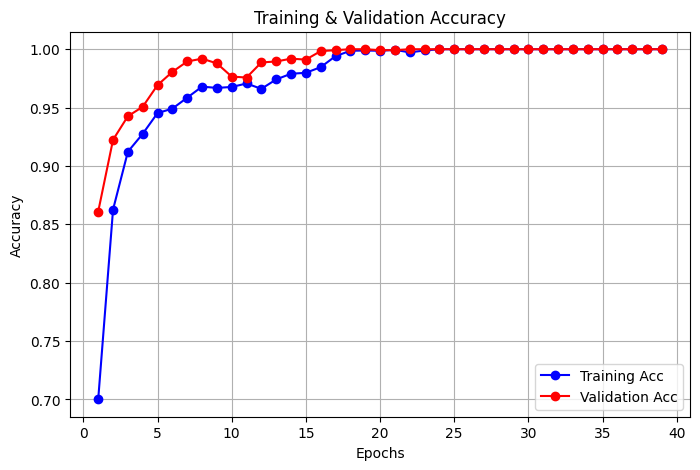

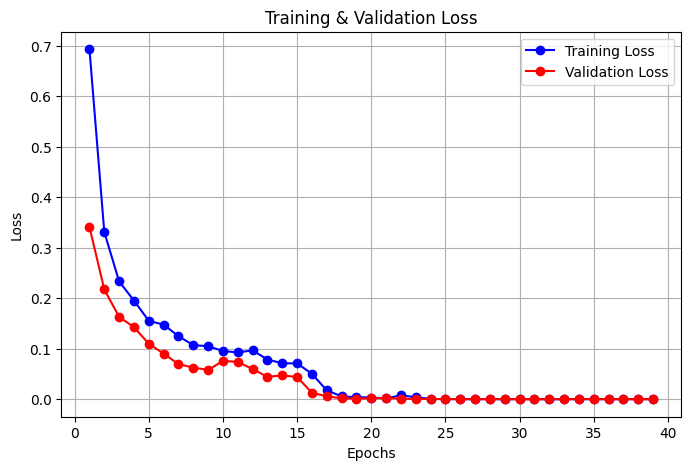

In [ ]:
def plot_training(history):
    acc = history["accuracy"]
    val_acc = history["val_accuracy"]
    loss = history["loss"]
    val_loss = history["val_loss"]
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(8,5))
    plt.plot(epochs, acc, "bo-", label="Training Acc")
    plt.plot(epochs, val_acc, "ro-", label="Validation Acc")
    plt.title("Training & Validation Accuracy")
    plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.legend(); plt.grid(True)
    plt.show()

    plt.figure(figsize=(8,5))
    plt.plot(epochs, loss, "bo-", label="Training Loss")
    plt.plot(epochs, val_loss, "ro-", label="Validation Loss")
    plt.title("Training & Validation Loss")
    plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.legend(); plt.grid(True)
    plt.show()

plot_training(full_history)

# ***`EVALUATE ON TEST SET`***

In [ ]:
print("\n=== Evaluating on test set ===")
loss, acc = model.evaluate(test_data)
print(f"Test Accuracy: {acc:.2%}")


=== Evaluating on test set ===
39/39 ━━━━━━━━━━━━━━━━━━━━ 919s 24s/step - accuracy: 1.0000 - loss: 1.0607e-04
Test Accuracy: 100.00%


# ***`CONFUSION MATRIX & REPORT`***

39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 189ms/step

Classification Report:
              precision    recall  f1-score   support

    Immature       1.00      1.00      1.00       368
      Mature       1.00      1.00      1.00       421
      Normal       1.00      1.00      1.00       448

    accuracy                           1.00      1237
   macro avg       1.00      1.00      1.00      1237
weighted avg       1.00      1.00      1.00      1237



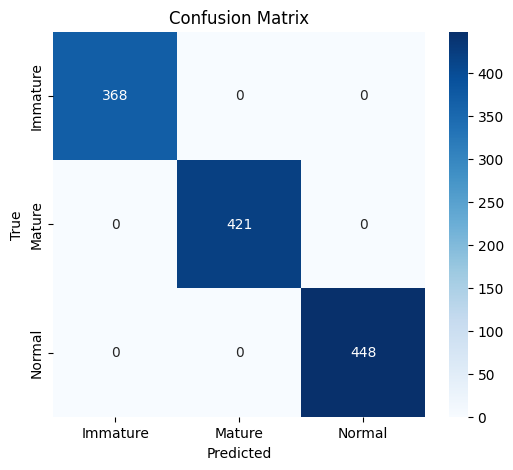

In [ ]:
y_true = test_data.classes
y_pred = np.argmax(model.predict(test_data), axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.show()

# ***`SAVE MODEL WITH ACCURACY IN NAME`***

In [ ]:
accuracy = acc * 100
model_name_h5 = f"1602020resnet_{accuracy:.2f}.h5"
model_name_keras = f"1602020resnet_{accuracy:.2f}.keras"

save_dir = "/content/drive/MyDrive/PROJECT1/trained models/"
os.makedirs(save_dir, exist_ok=True)

model.save(os.path.join(save_dir, model_name_h5))
model.save(os.path.join(save_dir, model_name_keras))

print(f"Models saved as: {model_name_h5}, {model_name_keras}")

Models saved as: 602020resnet_100.00.h5, 602020resnet_100.00.keras


Models saved as: 1602020resnet_100.00.h5, 1602020resnet_100.00.keras


PREDICTION FUNCTION

In [ ]:
def predict_image(model_path, img_path):
    model = tf.keras.models.load_model(model_path, compile=False)
    img = image.load_img(img_path, target_size=IMG_SIZE)
    x = image.img_to_array(img)
    x = preprocess_input(x)
    x = np.expand_dims(x, axis=0)
    preds = model.predict(x)[0]
    idx = np.argmax(preds)
    return CLASS_NAMES[idx], float(preds[idx]), preds

In [ ]:
label, conf, probs = predict_image(os.path.join(save_dir, model_name_h5), "/content/drive/My Drive/PROJECT1/data/data_set_20_20_60/test/Mature/Mature (1).jpg")
print(f"Predicted: {label} (confidence {conf:.2%})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted: Mature (confidence 100.00%)


In [ ]:
label, conf, probs = predict_image(os.path.join(save_dir, model_name_h5), "/content/drive/My Drive/PROJECT1/data/data_set_20_20_60/test/Immature/Immature (1).jpg")
print(f"Predicted: {label} (confidence {conf:.2%})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted: Immature (confidence 100.00%)


In [ ]:
label, conf, probs = predict_image(os.path.join(save_dir, model_name_h5), "/content/drive/My Drive/PROJECT1/data/data_set_20_20_60/test/Normal/Normal (1).jpg")
print(f"Predicted: {label} (confidence {conf:.2%})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted: Normal (confidence 100.00%)


In [ ]:
print(model_name_h5)

1602020resnet_100.00.h5


In [ ]:
label, conf, probs = predict_image(os.path.join(save_dir, model_name_h5), "/content/Mature (1).png")
print(f"Predicted: {label} (confidence {conf:.2%})")

NameError: name 'predict_image' is not defined